In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

(1440, 1080)


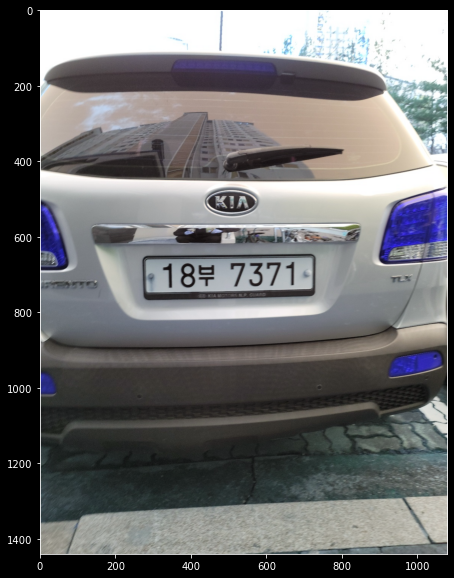

In [2]:
# 이미지 불러오기
img_ori = cv2.imread('car8.jpg')

# Gray Scale로 이미지를 가져옴
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

# 높이, 너비, 채널 수
height, width, channel = img_ori.shape

print(gray.shape)
plt.figure(figsize = (12, 10))
plt.imshow(img_ori, cmap='gray')

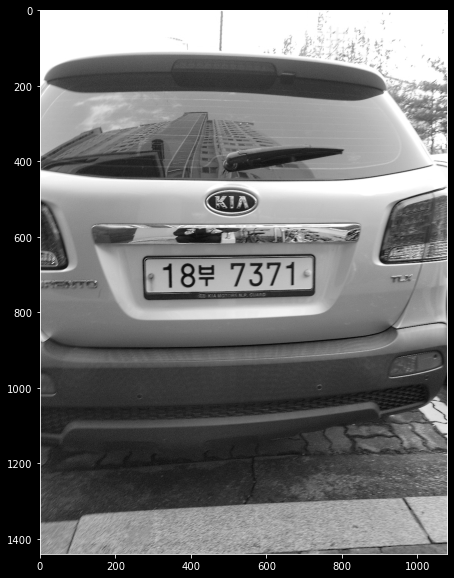

In [3]:
# 정방향 필터 커널
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# 밝기 값이 크게 변화하는 영역 강조
imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)

# 어두운 부분 강조
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat) # 밝은 부분은 더 밝게
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat) # 어두운 부분은 더 어둡게 표현


plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

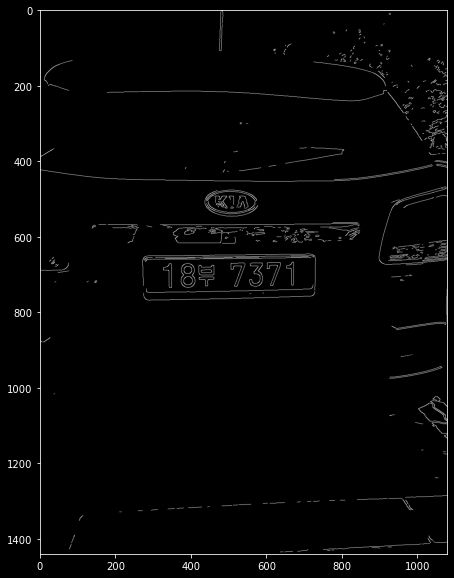

In [4]:
# 가우시안 블러 적용 > 이미지 노이즈 제거
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

# Canny edge
canny = cv2.Canny(img_blurred, 200, 255)
plt.figure(figsize=(12, 10))
plt.imshow(canny, cmap='gray')

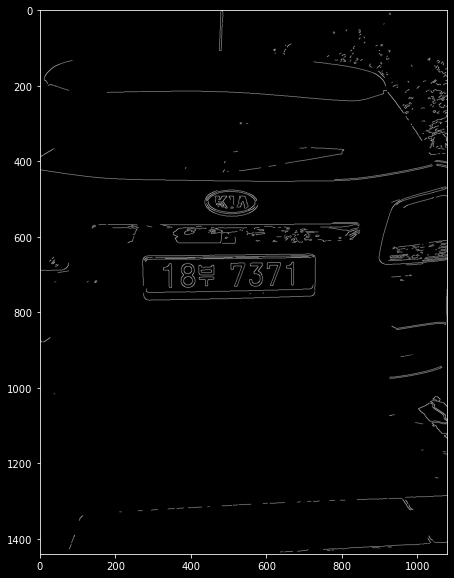

In [5]:
# 윤곽선 찾기
contours, _ = cv2.findContours(
    canny, 
    mode=cv2.RETR_TREE, 
    method=cv2.CHAIN_APPROX_SIMPLE)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# 윤관선 그리기
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

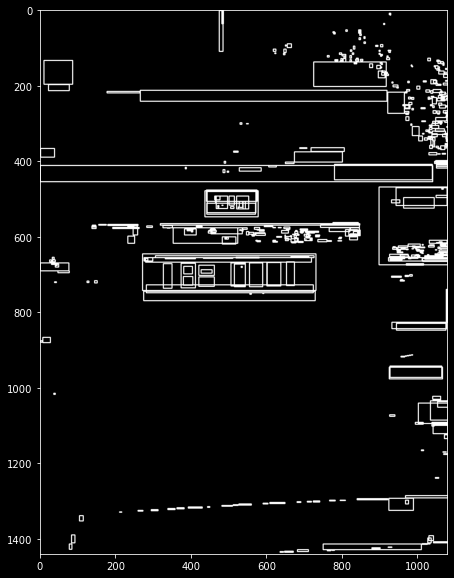

In [6]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

# 윤곽선의 좌표값을 활용하여 윤곽선을 감싸는 사각형 그리기
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour) #윤곽선의 사각형 범위를 찾음
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2) #윤곽선을 감싸고 있는 사각형을 그림
    
    # 필요한 값 저장
    contours_dict.append({
        'contour': contour, 'x': x, 'y': y, 'w': w, 'h': h, 'cx': x + (w / 2), 'cy': y + (h / 2)})

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

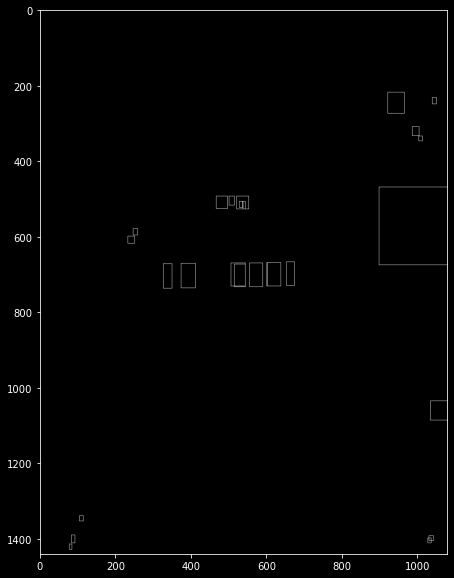

In [7]:
# 번호판으로 추정되는 사각형을 찾아냄
MIN_AREA = 90 # 번호판 글자의 크기(Bounding Rect 최소 크기)
MIN_WIDTH, MIN_HEIGHT = 2, 6 # Bounding Rect의 최소 너비와 높이
MIN_RATIO, MAX_RATIO = 0.25, 1 # Bounding Rect의 최소, 최대 비율

# 조건을 만족하는 윤곽선을 따로 저장
possible_contours = []

cnt = 0
# 면적과 비율을 구함
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    # 아래의 조건을 만족할 시 possible_contours에 따로 윤곽선 저장
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# 조건을 만족하는 Rect 그리기
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=1)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

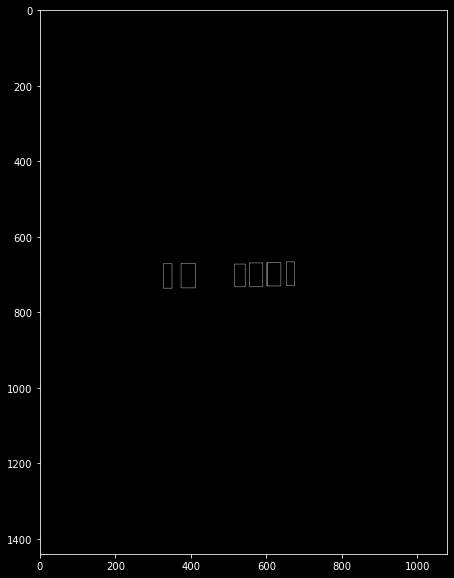

In [8]:
# possible_contours의 정렬 방식을 확인하여 번호판일 가능성이 높은 배열을 찾아냄
MAX_DIAG_MULTIPLYER = 5 # 5, 
MAX_ANGLE_DIFF = 15.0 # 15.0, 배열의 각을 판단
MAX_AREA_DIFF = 0.5 # 0.5, 면적의 차이 판단
MAX_WIDTH_DIFF = 0.8 # 너비의 차이 판단
MAX_HEIGHT_DIFF = 0.2 # 높이 차이 판단
MIN_N_MATCHED = 3 # 3 # 위의 조건을 만족하는 배열이 3개 이상일 때 번호판이라고 인식

def find_chars(contour_list):
    matched_result_idx = []
    
    # 두개의 윤곽선을 비교
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            # 같은 윤곽선인 경우 Continue
            if d1['idx'] == d2['idx']:
                continue
            
    
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            # 두 윤곽선의 대각선 길이
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
    
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx)) # 각도
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']) # 면적
            width_diff = abs(d1['w'] - d2['w']) / d1['w'] # 너비
            height_diff = abs(d1['h'] - d2['h']) / d1['h'] # 높이
            
            
            # 기준 충족시 append
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])
        
        # 후보의 갯수가 MIN_N_MATCHED보다 작을 경우 제외
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
        
        # 최종 후보군에 append
        matched_result_idx.append(matched_contours_idx)
        
        # 최종 후보군이 아닌 후보군에서 다시 후보군을 뽑음
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # 재귀
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# 최종 후보군 출력
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:

        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=1)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

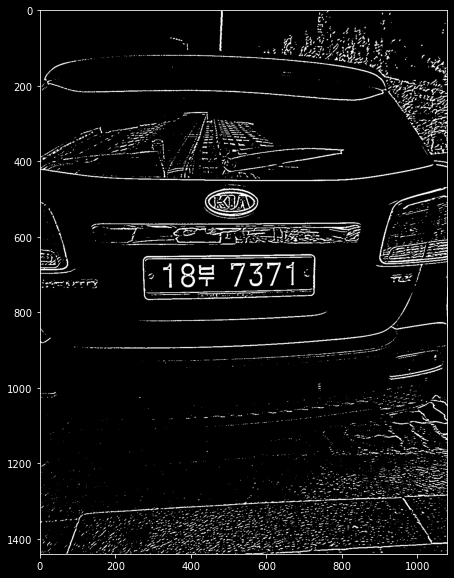

In [9]:
# 가우시안 블러 적용 > 이미지 노이즈 제거
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

# Threshold
img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=9, # 값이 높을 수록 선이 짙어짐
    C=6 # 값이 클수록 지워지는 부분이 많음
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

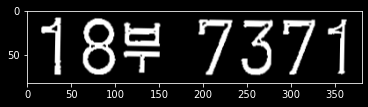

In [10]:
# Rotation되어 있는 번호판을 직선으로 변환(Affine Transform)
PLATE_WIDTH_PADDING = 1.1 # 1.3
PLATE_HEIGHT_PADDING = 1.3 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    # 얼마나 Rotation되어 있는지 Theta값 구함
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    # Rotation Matrix
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

    
    # Affine Transform
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    # Image Crop(번호판 부분)
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

18부7371


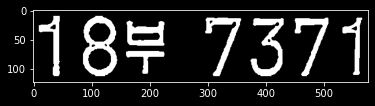

In [11]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    
    # 간단한 Thresholding 진행
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # 윤곽선 추출
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0
    
    # 위에서 설정한 윤곽선 기준을 충족하는지 확인
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    # 글씨를 잘 인식할 수 있게 블러 처리
    img_result = cv2.GaussianBlur(img_result, ksize=(5, 5), sigmaX=0)

    # 블러 처리 후 Thresholding
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # 여백만큼 이미지 크기 확대
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    
    # pytesseract를 활용하여 글자 추출
    pytesseract.pytesseract.tesseract_cmd = 'C:/Users/hyeon/AppData/Local/Programs/Tesseract-OCR/tesseract.exe'
    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    
    # 번호판(숫자, 문자로 구성)과 잘 맞는지 확인
    result_chars = ''
    has_digit = False
    for c in chars:

        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)
    
    # 특수문자 등을 삭제하고 숫자존재하고 문자열 길이가 7 or 8인 배열을 번호판으로
    if has_digit and len(result_chars) >= 7 and len(result_chars) <= 8:
        # 조금 더 정확하게 하기 위해 맨 뒤 부터 4개의 문자가 숫자로만 이루어져 있는지 확인
        if result_chars[-4:].isdigit():
            idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

18부7371


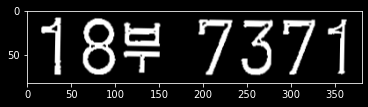

In [12]:
plt.imshow(plate_imgs[idx], cmap='gray')
print(plate_chars[idx])

18부7371


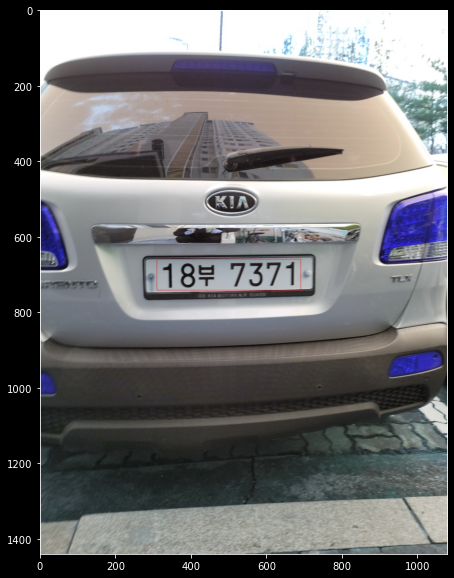

In [13]:
info = plate_infos[idx]
chars = plate_chars[idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=1)

# 파일 저장
# cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)
plt.show()